In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pybaseball import batting_stats_range
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint

In [15]:
from pybaseball import pitching_stats, batting_stats
data = batting_stats(2015,2021)

with open('batting_stats_columns.txt', 'w') as f:
    for column in data.columns:
        f.write(column + '\n')

In [39]:
from pybaseball import pitching_stats, batting_stats
import pandas as pd

# Fetching data from 2015 to 2021
data_train = pd.DataFrame()
for year in range(2015, 2022):
    yearly_data = batting_stats(year)
    data_train = data_train.append(yearly_data, ignore_index=True)

# Fetching data for 2022 and 2023
data_test = pd.DataFrame()
for year in range(2022, 2024):
    yearly_data = batting_stats(year)
    data_test = data_test.append(yearly_data, ignore_index=True)

# Filter the data to include only the statistics you mentioned
# The following assumes that the column names in pybaseball are as listed. Verify and adjust if necessary.
columns = ['IDfg','Name','Team','Age','PA','HR','AVG','FB',
           'FB%','HR/FB','ISO','SLG','wOBA','wRC+','Barrels','Barrel%',
           'HardHit','HardHit%','EV','LA','maxEV','Pull%','LD%','Hard%']

data_train = data_train[columns]
data_test = data_test[columns]


/var/folders/bt/ywylyt_d1cj78rzjtnlw2zx80000gn/T/ipykernel_3486/265340870.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_train = data_train.append(yearly_data, ignore_index=True)
/var/folders/bt/ywylyt_d1cj78rzjtnlw2zx80000gn/T/ipykernel_3486/265340870.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_train = data_train.append(yearly_data, ignore_index=True)
/var/folders/bt/ywylyt_d1cj78rzjtnlw2zx80000gn/T/ipykernel_3486/265340870.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_train = data_train.append(yearly_data, ignore_index=True)
/var/folders/bt/ywylyt_d1cj78rzjtnlw2zx80000gn/T/ipykernel_3486/265340870.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define which columns need to be scaled and which need to be encoded
numeric_features = ['Age','PA','AVG','FB',
                    'FB%','HR/FB','ISO','SLG','wOBA','wRC+','Barrels','Barrel%',
                    'HardHit','HardHit%','EV','LA','maxEV','Pull%']
categorical_features = ['IDfg','Name','Team']

# Define transformers
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

# Combine transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocess the training data
X_train = preprocessor.fit_transform(data_train.drop(['HR'], axis=1))
y_train = data_train['HR'].values

# Preprocess the test data
X_test = preprocessor.transform(data_test.drop(['HR'], axis=1))
y_test = data_test['HR'].values

/Users/andynguyen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [68]:
# Assuming X_train is your data that has been preprocessed appropriately for an RNN
number_of_samples = X_train.shape[0]     # The total number of sequences
timesteps = X_train.shape[1]             # The number of timesteps in each sequence
features_per_timestep = X_train.shape[2] # The number of features per timestep

In [69]:
number_of_samples

982

In [70]:
timesteps

769

In [71]:
features_per_timestep

1

In [73]:
# Create the GRU Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam

# Assuming X_train's shape is suitable for GRU. If not, you might need to reshape.
model = Sequential()
model.add(GRU(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(GRU(units=32, return_sequences=True))
model.add(Dropout(rate=0.5))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(rate=0.5))
model.add(Dense(units=1, activation="relu"))  # Outcome is a single value, the predicted number of home runs
model.compile(loss= "mse", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])
# Model summary

model.summary()


/Users/andynguyen/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_24 (GRU)                    │ (None, 769, 64)        │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_25 (GRU)                    │ (None, 769, 32)        │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 769, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 24608)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │     3,149,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,172,353 (12.10 MB)

 Trainable params: 3,172,353 (12.10 MB)

 Non-trainable params: 0 (0.00 B)

In [79]:
# Train the model
# Reshape input if necessary
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Correctly compute class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)

# Convert the class weights to a dictionary because Keras expects class weights in this format
class_weights_dict = dict(zip(np.unique(y_train), class_weights))

class_weights_dict_int_keys = {int(key): value for key, value in class_weights_dict.items()}

# Detecting the highest class label
max_class_label = max(class_weights_dict_int_keys.keys())

# Ensuring continuity by replacing missing class with 0 as weight
adjusted_class_weights = {i: class_weights_dict_int_keys.get(i, 0) for i in range(max_class_label + 1)}

filepath = "Advanced/saved-model-{epoch:03d}-{val_accuracy:.4f}.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# Train the model
history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=64, 
                    validation_split=0.2,
                    callbacks=[checkpoint],
                    shuffle=True,
                    class_weight=adjusted_class_weights)


Epoch 1/50


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 9.7991e-05 - loss: 78.7864
Epoch 1: val_accuracy improved from -inf to 0.01015, saving model to Advanced/saved-model-001-0.0102.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 415ms/step - accuracy: 1.8198e-04 - loss: 78.5744 - val_accuracy: 0.0102 - val_loss: 12.3856
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.0016 - loss: 58.1663
Epoch 2: val_accuracy did not improve from 0.01015
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 419ms/step - accuracy: 0.0016 - loss: 58.3162 - val_accuracy: 0.0102 - val_loss: 30.0029
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.0013 - loss: 45.5317
Epoch 3: val_accuracy did not improve from 0.01015
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 404ms/step - accuracy: 0.0013 - loss: 46.3245 - val_accuracy: 0.0051 - val_loss: 18.0502
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 7.1140e-04 - loss: 126.5217
Epoch 4: val_accuracy did not improve from 0.01015
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 404

In [83]:
# Train the model
# Reshape input if necessary
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Correctly compute class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)

# Convert the class weights to a dictionary because Keras expects class weights in this format
class_weights_dict = dict(zip(np.unique(y_train), class_weights))

class_weights_dict_int_keys = {int(key): value for key, value in class_weights_dict.items()}

# Detecting the highest class label
max_class_label = max(class_weights_dict_int_keys.keys())

# Ensuring continuity by replacing missing class with 0 as weight
adjusted_class_weights = {i: class_weights_dict_int_keys.get(i, 0) for i in range(max_class_label + 1)}

filepath = "Advanced/saved-model-{epoch:03d}-{val_accuracy:.4f}.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# Train the model
history = model.fit(X_train, y_train, 
                    epochs=1000, 
                    batch_size=64, 
                    validation_split=0.2,
                    callbacks=[checkpoint],
                    shuffle=True,
                    class_weight=adjusted_class_weights)

Epoch 1/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 4.2761e-04 - loss: 33.8379
Epoch 1: val_accuracy improved from -inf to 0.01015, saving model to Advanced/saved-model-001-0.0102.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 400ms/step - accuracy: 4.8806e-04 - loss: 33.8881 - val_accuracy: 0.0102 - val_loss: 24.7400
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 7.1140e-04 - loss: 35.4286
Epoch 2: val_accuracy did not improve from 0.01015
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 411ms/step - accuracy: 7.5157e-04 - loss: 35.3673 - val_accuracy: 0.0102 - val_loss: 30.1010
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.0000e+00 - loss: 43.4285
Epoch 3: val_accuracy did not improve from 0.01015
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 408ms/step - accuracy: 0.0000e+00 - loss: 43.8222 - val_accuracy: 0.0102 - val_loss: 50.3852
Epoch 4/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 3.0742e-04 - loss: 36.3525
Epoch 4: val_accuracy did not improve from 0.01015

In [84]:
# Evaluate the model

from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

# Reshape the test data if reshaping was applied to the training data
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Root Mean Square Error (RMSE): {rmse:.3f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
Mean Absolute Error (MAE): 1.802
Root Mean Square Error (RMSE): 2.300


In [85]:
y_test

array([62, 32, 30, 21, 35, 37, 28, 35, 26, 22, 29, 21, 25, 17, 15,  9, 38,
       23, 13, 28, 16, 18, 27, 30, 27, 31, 24,  6, 22, 25, 33, 36, 27, 17,
       31, 10, 26, 27, 23, 24, 14, 34, 40, 15,  9, 11, 17, 27, 16, 17, 22,
       34,  8, 28, 20, 12, 32, 16, 24,  7, 13, 27,  5, 14, 46, 27, 20, 13,
        9, 11, 33, 32, 25, 29, 15, 13, 13, 21, 30, 20, 20, 17, 15, 14, 20,
       17,  0, 17,  6, 17, 25, 19, 22, 16, 15, 13, 17, 12, 13, 19, 14, 11,
        4,  7, 11, 29, 11, 25, 17,  3, 16, 18, 19,  6, 35, 17,  1, 14, 14,
       22, 17, 16, 19, 18, 17, 23, 16, 13, 10,  8, 41, 39, 29, 54, 44, 29,
       33, 25, 31, 32, 30, 35, 17, 37, 24, 20, 38, 29, 19, 22, 39, 22, 30,
        9, 28, 18, 24, 19, 23, 19, 25, 17, 31, 25, 25, 19, 26, 33, 18, 15,
       14, 33, 20, 26, 25, 15, 21, 30, 17, 10, 24, 40, 21, 22, 23, 15, 20,
       25, 14, 22, 33, 36,  5, 46, 28, 10, 26, 28, 26, 10, 34, 26, 23, 24,
       17, 13, 16, 18, 14, 20, 23, 17, 17, 24, 21, 18, 30, 13, 36,  4, 21,
       24, 23, 26, 13, 11

In [86]:
y_pred

array([[55.456573 ],
       [31.660946 ],
       [31.84212  ],
       [19.830322 ],
       [32.262867 ],
       [39.588234 ],
       [25.78623  ],
       [32.369446 ],
       [25.606037 ],
       [19.80224  ],
       [29.07587  ],
       [19.018785 ],
       [21.413364 ],
       [16.707195 ],
       [12.525686 ],
       [ 6.450164 ],
       [36.092945 ],
       [24.467165 ],
       [14.991337 ],
       [29.306885 ],
       [13.668903 ],
       [19.949608 ],
       [26.993422 ],
       [24.169436 ],
       [23.922558 ],
       [27.395388 ],
       [22.242249 ],
       [ 5.5778284],
       [19.018705 ],
       [24.37286  ],
       [27.83047  ],
       [32.708965 ],
       [25.48545  ],
       [13.587211 ],
       [35.64781  ],
       [ 8.466584 ],
       [24.751343 ],
       [25.798992 ],
       [21.225262 ],
       [22.358555 ],
       [12.571862 ],
       [35.00341  ],
       [43.14981  ],
       [14.774504 ],
       [ 6.6356716],
       [12.302317 ],
       [15.806003 ],
       [27.95

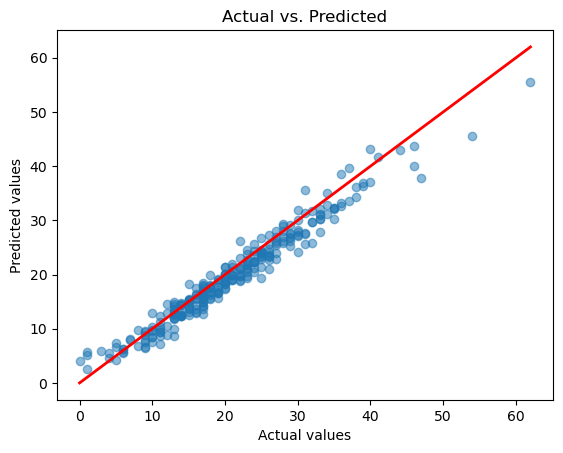

In [87]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs. Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)  # Diagonal line
plt.show()

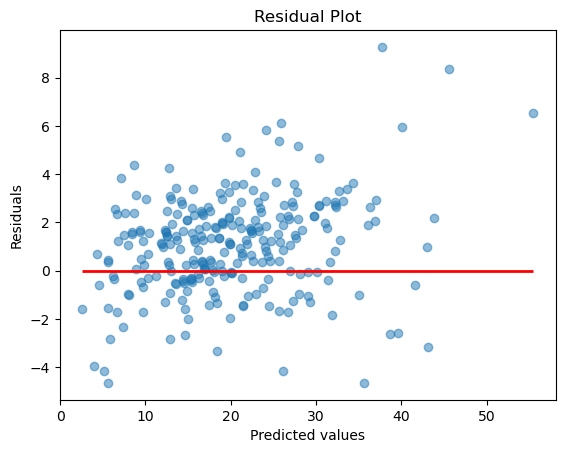

In [88]:
residuals = y_test - y_pred.flatten()
plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), color='red', linewidth=2)
plt.show()


/var/folders/bt/ywylyt_d1cj78rzjtnlw2zx80000gn/T/ipykernel_3486/4070226353.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals, bins=30, kde=True)


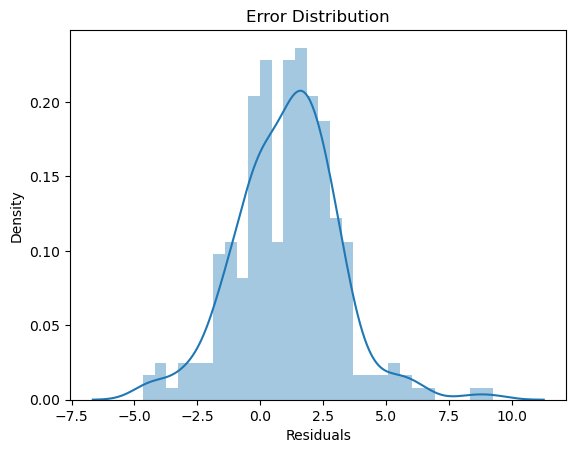

In [91]:
import seaborn as sns
sns.distplot(residuals, bins=30, kde=True)
plt.xlabel('Residuals')
plt.title('Error Distribution')
plt.show()

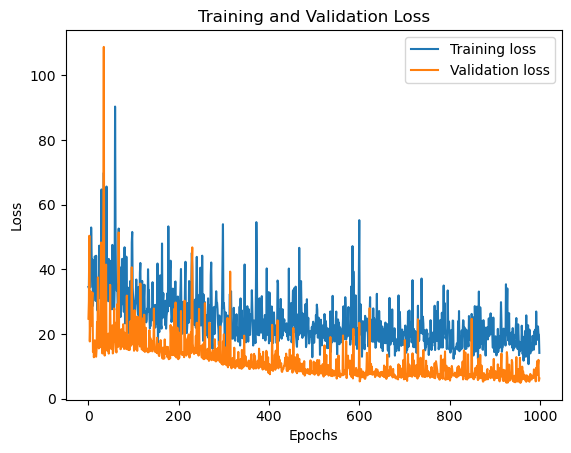

In [92]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()